In [ ]:
! pip3 install pixellib

In [ ]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(4032, 3024, 3)


<function matplotlib.pyplot.show>

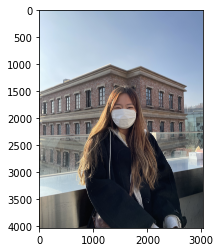

In [ ]:
img_path = '/content/drive/MyDrive/images/IMG_2668-2.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig,cv2.COLOR_BGR2RGB))
plt.show

## Segmentation
- 이미지에서 픽셀단위로 관심 객체를 추출하는 방법
- 모든 픽셀에 라벨을 할당하고 같은 라벨은 '공통적인 특징' 을 가진다고 가정 

  ### Semantic Segmentation
  - 물리적 의미 단위로 인식하는 segmentation
  - 이미지에서 픽셀을 사람,자동차,비행기 등의 물리적 단위로 분류(classification)하는 방법

  ### Instance Segmentation
  - 사람 개개인 별로 다른 라벨을 가지게 해 여러사람이 한 이미지에 등장해도 객체를 분할해서 인식하게 함

*cf.* Watershed segmentation : 딥러닝에 기반한 방법이 있기 전, 이미지를 greyscale 로 변경하여 물체의 경계를 나누어 segmentation함

## DeepLab 
### Atrous convolution
- 기존의 convolution 과 다르게 filter 내부에 빈 공간을 둔 채로 작동한다
- 기존의 convolution 과 동일한 양의 parameter 와 계산량을 유지하면서 receptive feild 를 크게 가져갈 수 있게 된다

### Spatial Pyramid Pooling 
- feature map 으로부터 여러개의 rate 가 다른 atrous convolution 을 병렬로 적용한뒤 이를 다시 합친다
- 보다 정확한 segmentation 이 가능하게 함 

### Depthwise Separable Convolution
- Convolution 연산에서 channel축을 filter 가 한번에 연산하지 않고 channel 축을 모두 분리시킨뒤, 여러개의 colvolutional filter로 대체시킨 연산
- 그 연산을 통해 나온 결과에 대해 1*1*C 크기의 convolutional filter 를 적용
- 기존의 convolution 과 유사한 성능을 보이면서 사용되는 parameter 수 와 연산량을 획기적으로 줄일 수 있음

#### *1.DeepLab Download*

In [ ]:
model_dir = '/content/drive/MyDrive/images/model'
model_file = os.path.join(model_dir,'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# start download
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/images/model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f9d271e1890>)

#### *2.put Image into model*

In [ ]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

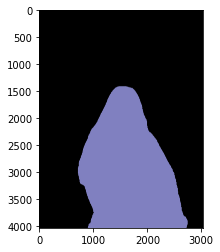

In [ ]:
plt.imshow(output)
plt.show()

In [ ]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [ ]:
for class_id in segvalues['class_ids']:
  print(LABEL_NAMES[class_id])

background
person


In [ ]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [ ]:
colormap[15]

array([192, 128, 128])

In [ ]:
# because output image has BGR order, and colormap has RGB
seg_color = (128,128,192)

(4032, 3024)


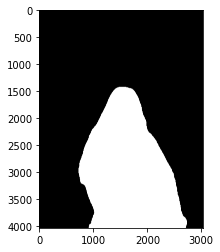

In [ ]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

#### *3.compare with original image*

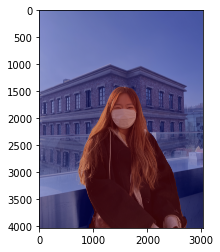

In [ ]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### *4.blurr background*

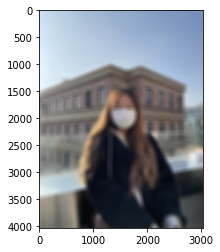

In [ ]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

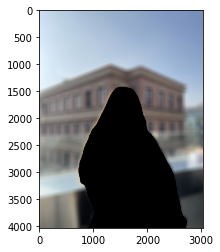

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### *5.combining the original image and blurred background*

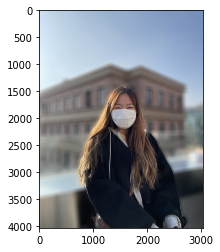

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

####*6.combining the original image with new background*

(4032, 3024, 3)


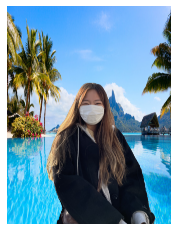

In [ ]:
new_path = '/content/drive/MyDrive/images/borabora.jpeg'
img_new = cv2.imread(new_path)
img_new = cv2.resize(img_new, dsize=(3024,4032), interpolation=cv2.INTER_AREA)
print(img_new.shape)
img_concat = np.where(img_mask_color==255, img_orig, img_new)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis("off") 

plt.show()

####*7.Transfering multiple images at once*
- 변환한 사진에서 이렇다 할 문제점이 보이지 않아 다른  여러가지 사진을 가져와봄
  - 여러명이 있는 사진
  - 밝기가 어두운 사진 
  - 배경이 복잡한 사진 
  - 강아지,고양이 사진

In [ ]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [ ]:
class portraitMode:
  def __init__(self,img_path,img_orig):
    self.img_path = img_path
    self.img_orig = img_orig

  def make_mask(self):
    segvalues, output = model.segmentAsPascalvoc(self.img_path)



    for class_id in segvalues['class_ids']:
      print(LABEL_NAMES[class_id])

    if class_id == 8 : output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE) # class id 8 = 'cat' # 고양이 필터에서 필터가 90도 돌아간 현상 발생, 원위치 시켜주기
    
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3


    colormap[class_id]
    seg_color = (colormap[class_id][2],colormap[class_id][1],colormap[class_id][0])

    seg_map = np.all(output==seg_color, axis=-1)
    print(seg_map.shape)
    return seg_map

    

  def check_mask(self, seg_map):
    img_show = img_orig.copy()
    img_mask = seg_map.astype(np.uint8) * 255

    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    return img_mask,img_show

  def blurring_background(self, img_mask):
    img_orig_blur = cv2.blur(self.img_orig, (100,100))  
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    return img_bg_blur, img_mask_color

  def combine_together(self,seg_map,img_show,img_bg_blur, img_mask_color):
    plt.subplot(1,4,1)
    plt.imshow(seg_map, cmap='gray')

    plt.subplot(1,4,2)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

    plt.subplot(1,4,3)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

    plt.subplot(1,4,4)
    img_concat = np.where(img_mask_color==255, self.img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))


    plt.show()




background
chair
person
(1280, 960)


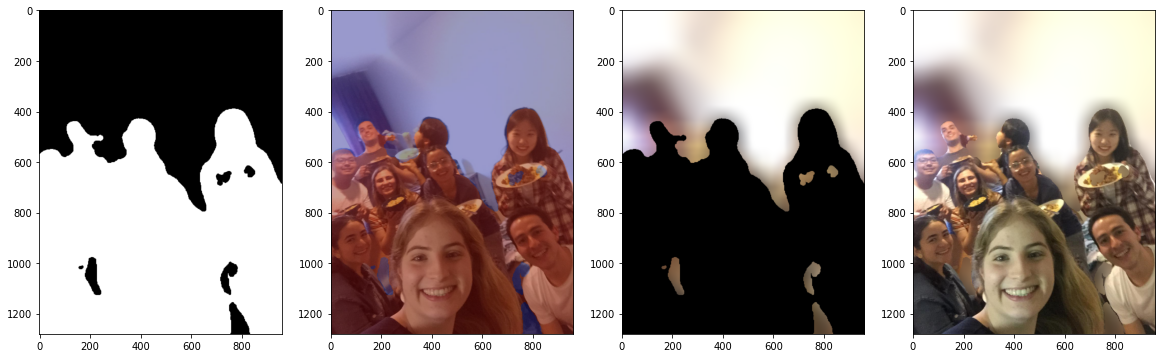

background
person
(1280, 960)


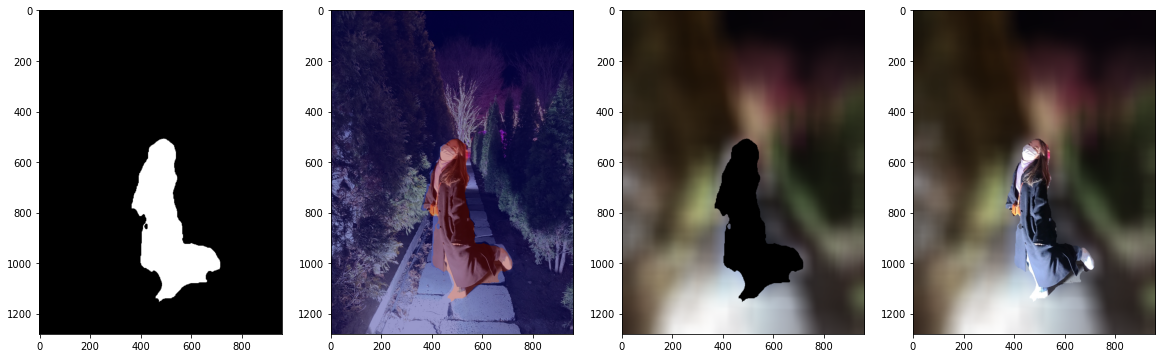

background
chair
diningtable
person
pottedplant
(3024, 2454)


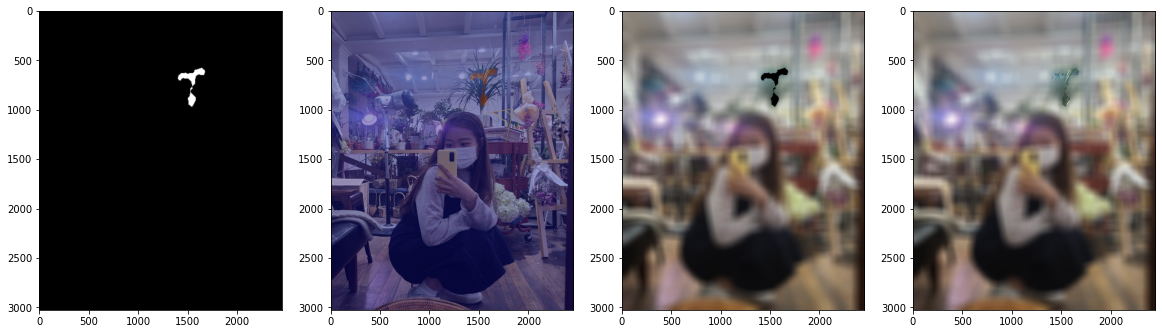

background
dog
(1386, 1920)


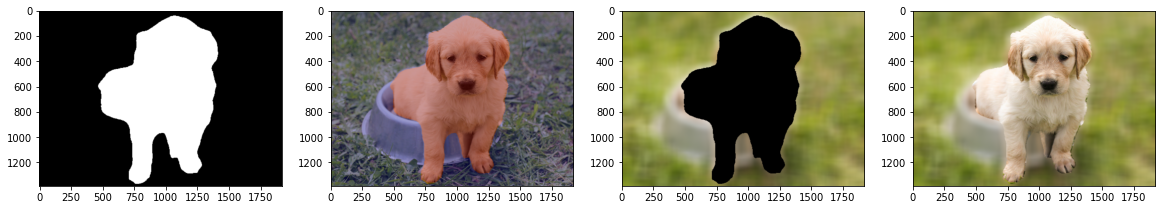

background
cat
(3024, 3024)


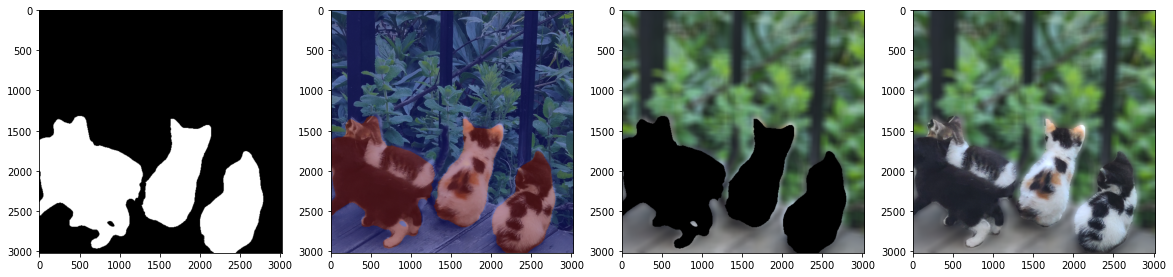

In [ ]:
img_paths = '/content/drive/MyDrive/images/'
img_file = ['jesspasta.JPG','IMG_3054.JPG','flowercafe.JPG','puppy-g811b00ff6_1920.jpg','babykitten.JPG']
for i in range(len(img_file)) :
  fig = plt.figure(i,figsize=(20,20))
  img_path = os.path.join(img_paths, img_file[i])
  img_orig = cv2.imread(img_path)
  a = portraitMode(img_path,img_orig) 
  k = a.make_mask()
  m,s = a.check_mask(k)
  b,c = a.blurring_background(m)
  a.combine_together(k,s,b,c)


####*8.Problems and Solutions suggestion*

>사진의 문제점 : <br>
  마스크의 경계선이 정확하지 않다<br>
  사람의 앞에 있는 물체( 예시 : 파스타 ) 도 얄짤없이 짤린다<br>
  배경이 복잡한 사진의 경우 인식하고자 하는 피사체를 직접 지정 해 주어야 한다


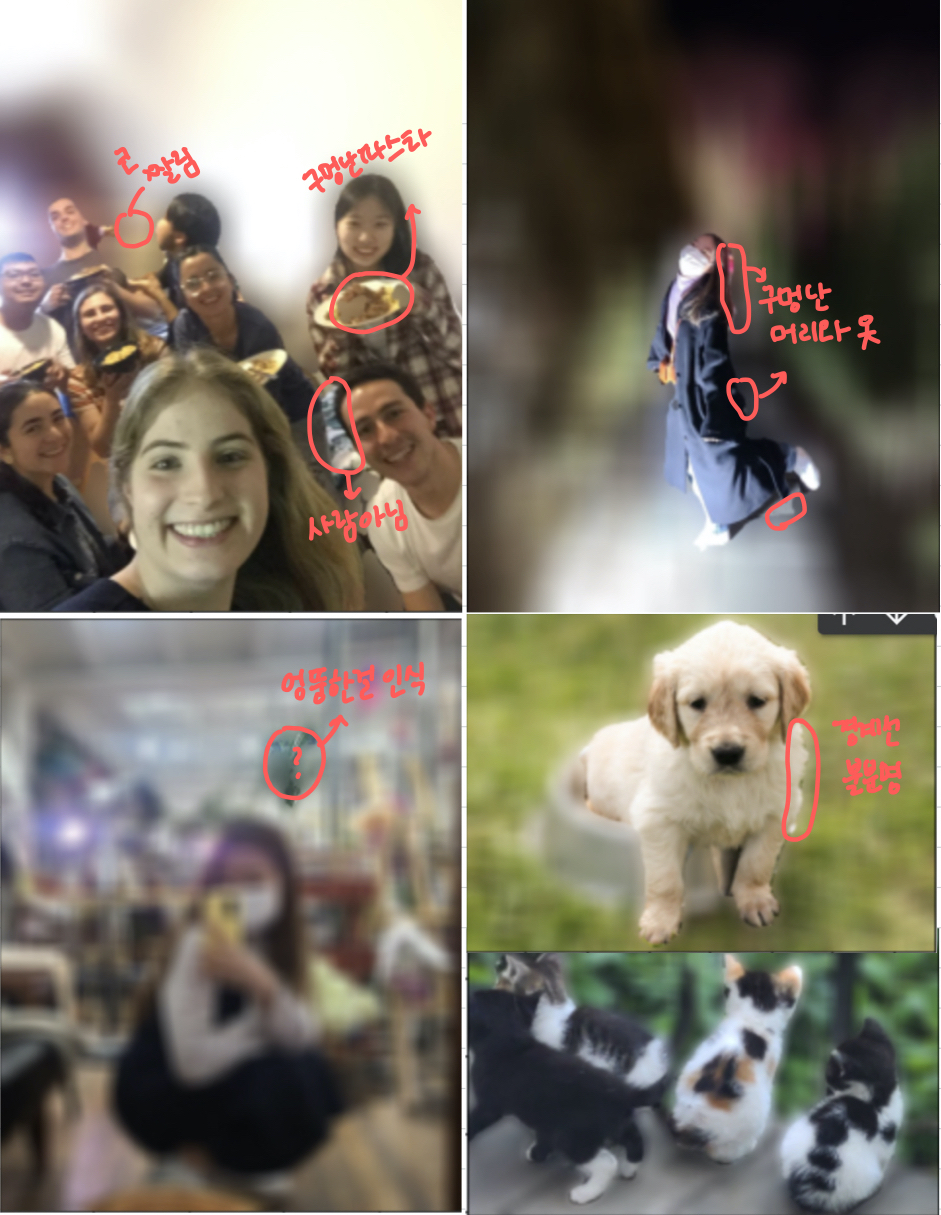

 *해결방안 제시*

 >Struct2Depth : 픽셀 단위의 RGB 정보 뿐 아니라 깊이 관계까지 예측하는 방법

- 단순히 아웃 포커싱만 이용한 segmentation 보다는 `struct2depth` 를 이용해 background 와 사물 간의 깊이 관계 까지 파악할 수 있다면 정확도가 올라 갈 것으로 기대 된다. <br>
- 또한 깊이를 이용해서 사람보다 앞에 있는(파스타 그릇이나 핸드폰)도 피사체로 함께 인식 시킬 수 있지 않을까 라고 생각 이 든다. <br>
- 또한 사진의 픽셀 수가 작거나, 어둡거나 한 사진들에서 정확도가 더 낮은 결과를 낸 것을 토대로 보아
애초에 input data 의 화질이나 밝기들을 미리 조절 하는 것 도 방법이지 않을까 생각이 든다.<br>
- segmentation 에서 downsampling 시에 정보의 손실을 최소화 하는 방법을 찾는 것도 추상적이지만 한가지 방법이 될 수 있을 것 같다.